# Recommender System Evaluations
> Understanding evaluation metrics, splitting methods

- toc: true
- badges: true
- comments: true
- categories: [Evaluation, Splitting]
- image:

In [ ]:
import numpy as np
 
def mean_reciprocal_rank(rs):
  rs = (np.asarray(r).nonzero()[0] for r in rs)
  return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])
 
mean_reciprocal_rank([[0,0,1],[0,1,1],[1,1,0]])

0.611111111111111

In [ ]:
import numpy as np
 
def r_precision(r):
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])
 
r_precision([0,0,1,1])

0.5

In [ ]:
import numpy as np
 
def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)
 
precision_at_k([0,0,1,1], 3)

0.3333333333333333

In [8]:
# import numpy as np

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

average_precision([0,0,1,1])

0.41666666666666663

In [9]:
import numpy as np

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

mean_average_precision([[0,0,1,1],[0,1]])

0.4583333333333333

In [18]:
import numpy as np

def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        elif method == 2:
            return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

dcg_at_k([3, 2, 3, 0, 1, 2], 6)

8.097171433256849

In [19]:
import numpy as np

def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

ndcg_at_k([3, 2, 3, 0, 1, 2], 6, method=1)

0.9488107485678985

In [22]:
import numpy as np
from typing import List

def novelty(predicted: List[list], pop: dict, u: int, n: int) -> (float, list):
    """
    Computes the novelty for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    pop: dictionary
        A dictionary of all items alongside of its occurrences counter in the training data
        example: {1198: 893, 1270: 876, 593: 876, 2762: 867}
    u: integer
        The number of users in the training data
    n: integer
        The length of recommended lists per user
    Returns
    ----------
    novelty:
        The novelty of the recommendations in system level
    mean_self_information:
        The novelty of the recommendations in recommended top-N list level
    ----------    
    Metric Defintion:
    Zhou, T., Kuscsik, Z., Liu, J. G., Medo, M., Wakeling, J. R., & Zhang, Y. C. (2010).
    Solving the apparent diversity-accuracy dilemma of recommender systems.
    Proceedings of the National Academy of Sciences, 107(10), 4511-4515.
    """
    mean_self_information = []
    k = 0
    for sublist in predicted:
        self_information = 0
        k += 1
        for i in sublist:
            self_information += np.sum(-np.log2(pop[i]/u))
        mean_self_information.append(self_information/n)
    novelty = sum(mean_self_information)/k
    return novelty, mean_self_information

novelty([['A','B','C'],['B','A']],
        {'A':10, 'B':10, 'C':10, 'D':10, 'E':10},
        2, 3)

(-1.9349400790728017, [-2.321928094887362, -1.5479520632582415])

In [26]:
from typing import List

def prediction_coverage(predicted: List[list], catalog: list) -> float:
    """
    Computes the prediction coverage for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    Returns
    ----------
    prediction_coverage:
        The prediction coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    prediction_coverage = round(unique_predictions/(len(catalog)* 1.0)*100,2)
    return prediction_coverage

prediction_coverage([['A','B','D'],['B','A','C']], ['A','B','C','D','E'])

80.0

In [32]:
import random
from typing import List

def catalog_coverage(predicted: List[list], catalog: list, k: int) -> float:
    """
    Computes the catalog coverage for k lists of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    Returns
    ----------
    catalog_coverage:
        The catalog coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage

catalog_coverage([['A','B','D'],['B','A','C'],['B','A','D']], ['A','B','C','D','E'], 2)

80.0

In [45]:
def recall_at_k(actual: list, predicted: list, k) -> int:
  if len(predicted)>k:
    predicted = predicted[:k]
  score = 0.0
  num_hits = 0.0
  if actual:
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    return score / len(actual)
  else:
    return 0.0

recall_at_k([1,2,3,4,5],[2,4,6,8,10],4), \
recall_at_k([2,3,7,8,9],[1,3,5,8,10],4)

(0.4, 0.2)

In [41]:
def mean_average_recall(actual: List[list], predicted: List[list], k=10) -> int:
    return np.mean([recall_at_k(a,p,k) for a,p in zip(actual, predicted)])

mean_average_recall([[1,2,3,4,5],[2,4,6,8,10]],
                    [[2,3,7,8,9],[1,3,5,8,10]],
                    4)

0.225

In [50]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def mse(y: list, yhat: np.array) -> float:
    mse = mean_squared_error(y, yhat)
    return mse

def rmse(y: list, yhat: np.array) -> float:
    rmse = sqrt(mean_squared_error(y, yhat))
    return rmse

rmse([1,4,3],[1,2,3])

1.1547005383792515

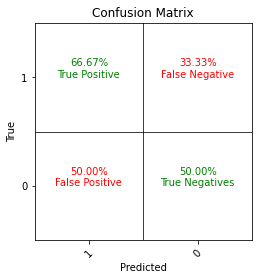

In [52]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y: list, yhat: list) -> None:
    cm = confusion_matrix(y, yhat, labels=[1,0])
    cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)*100

    fmt = ".2f"
    _ = cm.max() / 2. # TODO: Unused argument
    descriptions = np.array([["True Positive", "False Negative"], ["False Positive", "True Negatives"]])
    colors = np.array([["green", "red"], ["red", "green"]])
    plt.imshow([[0,0],[0,0]], interpolation='nearest', cmap=plt.cm.Greys)
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt)+'%\n' + descriptions[i, j],
                     horizontalalignment="center",
                     color=colors[i,j])
    plt.axhline(y=0.5, xmin=0, xmax=1, color="black", linewidth=0.75)
    plt.axvline(x=0.5, ymin=0, ymax=1, color="black", linewidth=0.75)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.xticks([0,1], [1,0], rotation=45)
    plt.yticks([0,1], [1,0])
    plt.show()

make_confusion_matrix([1,0,0,1,1],[1,1,0,0,1])

In [75]:
import random
from itertools import product
from math import sqrt
from typing import List

import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

def personalization(predicted: List[list]) -> float:
    """
    Personalization measures recommendation similarity across users.
    A high score indicates good personalization (user's lists of recommendations are different).
    A low score indicates poor personalization (user's lists of recommendations are very similar).
    A model is "personalizing" well if the set of recommendations for each user is different.
    Parameters:
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        The personalization score for all recommendations.
    """

    def make_rec_matrix(predicted: List[list]) -> sp.csr_matrix:
        df = pd.DataFrame(data=predicted).reset_index().melt(
            id_vars='index', value_name='item',
        )
        df = df[['index', 'item']].pivot(index='index', columns='item', values='item')
        df = pd.notna(df)*1
        rec_matrix = sp.csr_matrix(df.values)
        return rec_matrix

    #create matrix for recommendations
    predicted = np.array(predicted)
    rec_matrix_sparse = make_rec_matrix(predicted)

    #calculate similarity for every user's recommendation list
    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity
    personalization = np.mean(similarity[upper_right])
    return 1-personalization

def _single_list_similarity(predicted: list, feature_df: pd.DataFrame, u: int) -> float:
    """
    Computes the intra-list similarity for a single list of recommendations.
    Parameters
    ----------
    predicted : a list
        Ordered predictions
        Example: ['X', 'Y', 'Z']
    feature_df: dataframe
        A dataframe with one hot encoded or latent features.
        The dataframe should be indexed by the id used in the recommendations.
    Returns:
    -------
    ils_single_user: float
        The intra-list similarity for a single list of recommendations.
    """
    # exception predicted list empty
    if not(predicted):
        raise Exception('Predicted list is empty, index: {0}'.format(u))

    #get features for all recommended items
    recs_content = feature_df.loc[predicted]
    recs_content = recs_content.dropna()
    recs_content = sp.csr_matrix(recs_content.values)

    #calculate similarity scores for all items in list
    similarity = cosine_similarity(X=recs_content, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

def intra_list_similarity(predicted: List[list], feature_df: pd.DataFrame) -> float:
    """
    Computes the average intra-list similarity of all recommendations.
    This metric can be used to measure diversity of the list of recommended items.
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        Example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    feature_df: dataframe
        A dataframe with one hot encoded or latent features.
        The dataframe should be indexed by the id used in the recommendations.
    Returns:
    -------
        The average intra-list similarity for recommendations.
    """
    feature_df = feature_df.fillna(0)
    Users = range(len(predicted))
    ils = [_single_list_similarity(predicted[u], feature_df, u) for u in Users]
    return np.mean(ils)

In [54]:
!pip install -q funcsigs

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from funcsigs import signature
from matplotlib.lines import Line2D
from sklearn.metrics import (auc, average_precision_score,
                             precision_recall_curve, roc_curve)

In [55]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    interaction_type: str
        type of user-item interactions
        i.e. 'purchases', 'ratings' 'interactions', or 'clicks'
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)
    x_tables bool, default=True
        if True, plot x-axis tick labels
        if False, no x-axis tick lavels will be plotted.
    Returns:
    -------
        A long tail plot
    """
    #calculate cumulative volumes
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
        tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()

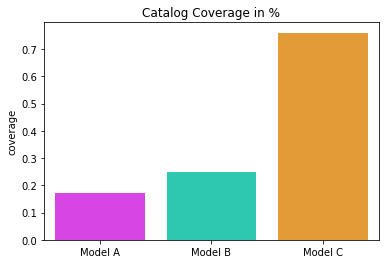

In [56]:
def coverage_plot(coverage_scores: list, model_names: list) -> None:
    """
    Plots the coverage for a set of models to compare.
    ----------
    coverage_scores: list
        list of coverage scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A coverage plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=coverage_scores)

    #set labels
    ax.set_title('Catalog Coverage in %')
    ax.set_ylabel('coverage')

    plt.show()

coverage_plot([0.17, 0.25, 0.76], ['Model A', 'Model B', 'Model C'])

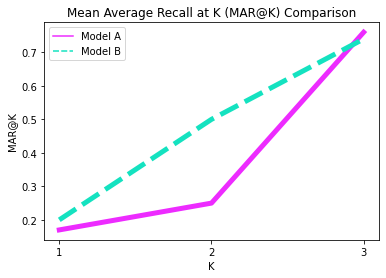

In [60]:
def mark_plot(mark_scores, model_names, k_range):
    """
    Plots the mean average recall at k for a set of models to compare.
    ----------
    mark_scores: list of lists
        list of list of mar@k scores over k. This list is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array identifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A mar@k plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mark_df = pd.DataFrame(np.column_stack(mark_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mark_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Recall at K (MAR@K) Comparison')
    ax.set_ylabel('MAR@K')
    ax.set_xlabel('K')

    plt.show()

mark_plot([[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]],
          ['Model A', 'Model B'],
          [1,2,3])

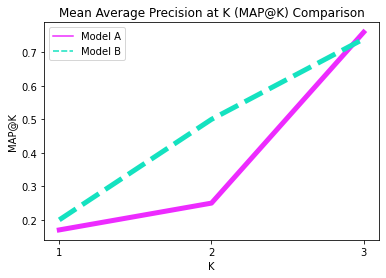

In [61]:
def mapk_plot(mapk_scores, model_names, k_range):
    """
    Plots the mean average precision at k for a set of models to compare.
    ----------
    mapk_scores: list of lists
        list of list of map@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A map@k plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mapk_df = pd.DataFrame(np.column_stack(mapk_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mapk_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Precision at K (MAP@K) Comparison')
    ax.set_ylabel('MAP@K')
    ax.set_xlabel('K')
    plt.show()

mapk_plot([[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]],
          ['Model A', 'Model B'],
          [1,2,3])

In [96]:
def roc_plot(actual, model_probs, model_names, figsize=(10,10)):
    """
    Receiver Operating Characteristic Plot. Can plot multiple models.
    ----------
    actual: array of dataframe of true classes assignements.
        example:
        [1,1,0,1,0]
    model_probs: list of arrays
        a list containing classification probabilites for each model in order.
        example:
        model_probs = [class_probs_1, class_probs_2]
    model_names: list of strings
        a list containing names for each model in order.
        example:
        model_names = ["GBT", "Logistic Regression"]
    figsize: size of figure
    Returns:
    -------
        Receiver Operating Characteristic Plot with AUC in the legend.
    """
    model_names = make_listy(model_names)
    if not is_listy(model_probs): model_probs = [model_probs]

    if len(model_names) > 5:
        return ValueError("Can only compare 5 models or less.")

    colors = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]

    for m in range(len(model_names)):
        fpr, tpr, _ = roc_curve(actual, model_probs[m])
        roc_auc = auc(fpr, tpr)
        ax = sns.lineplot(x=fpr,
                          y=tpr,
                          lw=2,
                          color=colors[m],
                          label = model_names[m] + ' AUC = %0.4f' % roc_auc)
    
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_title('Receiver Operating Characteristic Plot')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    
    plt.show()


def precision_recall_plot(targs, preds, figsize=(6,6)):
    """
    Plots the precision recall curve
    ----------
    targs: array-like true class labels
    preds: array-like predicted probabilities
    figsize: size of figure
    Returns:
    -------
        A precision and recall curve
    """
    average_precision = average_precision_score(targs, preds)
    precision, recall, _ = precision_recall_curve(targs, preds)
    plt.figure(figsize=figsize)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
        average_precision))
    plt.show()


def make_listy(p):
    if isinstance(p, str): return [p]
    try:
        _ = iter(p)
    except TypeError:
        p = [p]
    return p


def is_listy(x): return isinstance(x, (tuple,list))

def metrics_plot(model_names, metric_names, scores):
    fig = go.Figure()
    for model_name, *vals in zip(model_names, *scores):
        fig.add_trace(go.Scatterpolar(
              r=vals,
              theta=metric_names,
              fill='tonext',
              name=model_name
        ))
    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 100]
        )),
      showlegend=True
    )
    fig.show()

In [98]:
metrics_plot(['Model A', 'Model B', 'Model C'],
             ['Coverage','Personalization','Diversity'],
             [[17, 25, 76],
              [43, 23, 44],
              [23, 21, 69]])

In [ ]:
!pip install -q git+https://github.com/sparsh-ai/recochef.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.3MB 9.3MB/s 


In [ ]:
from recochef.datasets.movielens import MovieLens
data = MovieLens()
ratings = data.load_interactions()
ratings.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


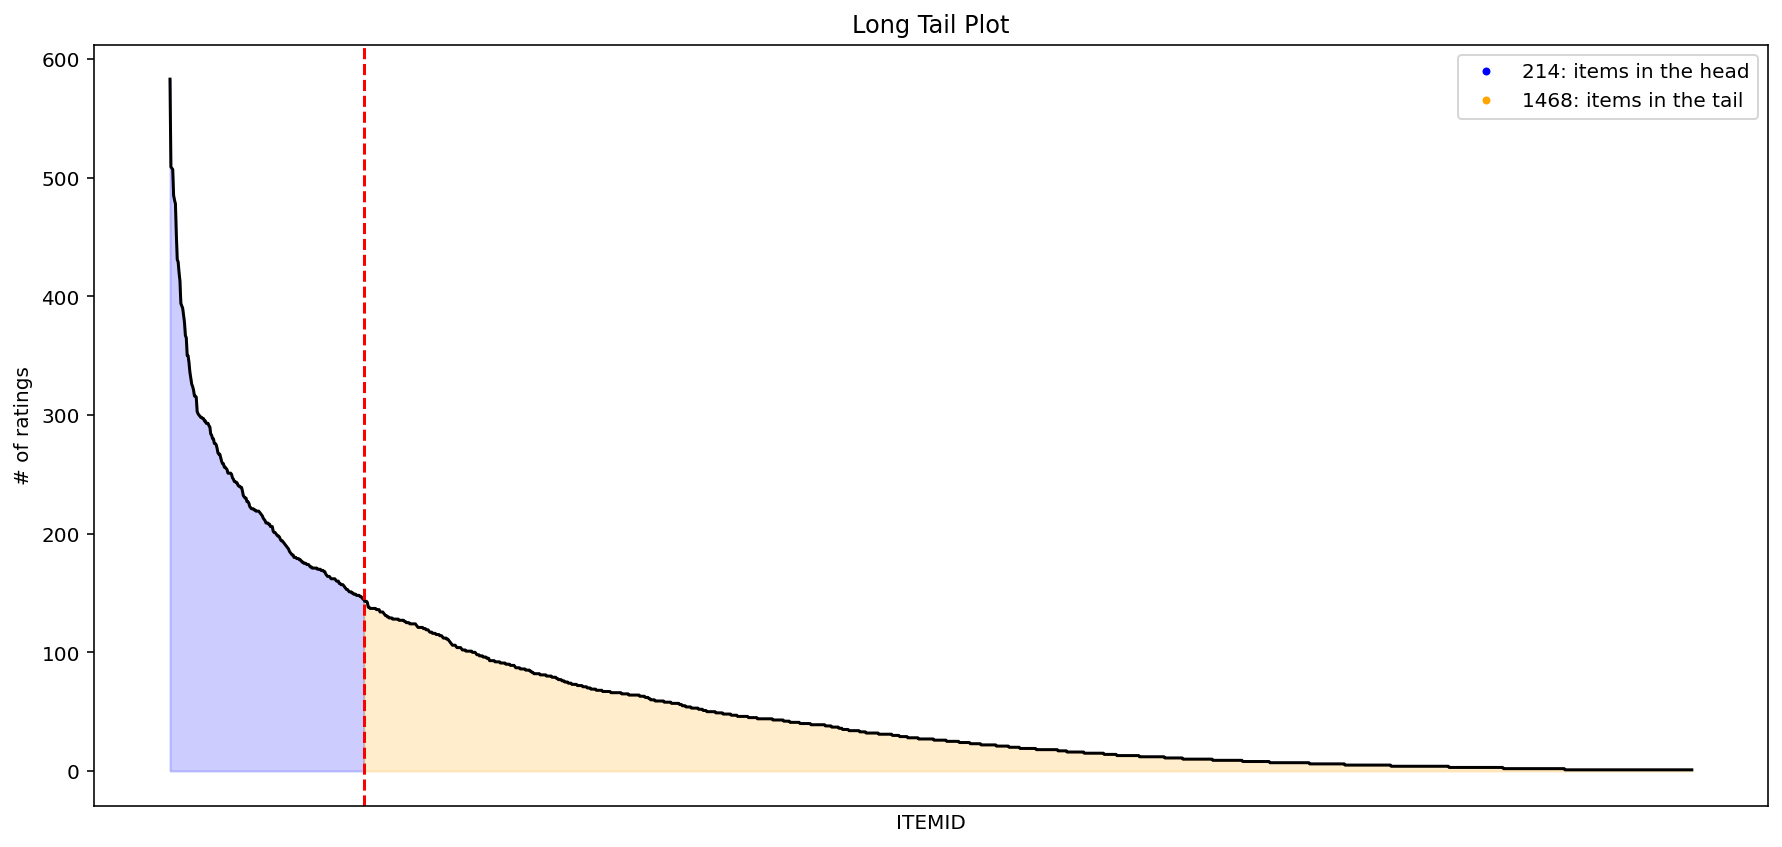

In [ ]:
fig = plt.figure(figsize=(15, 7))
long_tail_plot(ratings, 'ITEMID', 'ratings', percentage=0.5, x_labels=False)

In [ ]:
import numpy as np
from tqdm import tqdm


def sequential_evaluation(recommender,
                          test_sequences,
                          evaluation_functions,
                          users=None,
                          given_k=1,
                          look_ahead=1,
                          top_n=10,
                          scroll=True,
                          step=1):
    """
    Runs sequential evaluation of a recommender over a set of test sequences
    :param recommender: the instance of the recommender to test
    :param test_sequences: the set of test sequences
    :param evaluation_functions: list of evaluation metric functions
    :param users: (optional) the list of user ids associated to each test sequence. Required by personalized models like FPMC.
    :param given_k: (optional) the initial size of each user profile, starting from the first interaction in the sequence.
                    If <0, start counting from the end of the sequence. It must be != 0.
    :param look_ahead: (optional) number of subsequent interactions in the sequence to be considered as ground truth.
                    It can be any positive number or 'all' to extend the ground truth until the end of the sequence.
    :param top_n: (optional) size of the recommendation list
    :param scroll: (optional) whether to scroll the ground truth until the end of the sequence.
                If True, expand the user profile and move the ground truth forward of `step` interactions. Recompute and evaluate recommendations every time.
                If False, evaluate recommendations once per sequence without expanding the user profile.
    :param step: (optional) number of interactions that will be added to the user profile at each step of the sequential evaluation.
    :return: the list of the average values for each evaluation metric
    """
    if given_k == 0:
        raise ValueError('given_k must be != 0')

    metrics = np.zeros(len(evaluation_functions))
    with tqdm(total=len(test_sequences)) as pbar:
        for i, test_seq in enumerate(test_sequences):
            if users is not None:
                user = users[i]
            else:
                user = None
            if scroll:
                metrics += sequence_sequential_evaluation(recommender,
                                                          test_seq,
                                                          evaluation_functions,
                                                          user,
                                                          given_k,
                                                          look_ahead,
                                                          top_n,
                                                          step)
            else:
                metrics += evaluate_sequence(recommender,
                                             test_seq,
                                             evaluation_functions,
                                             user,
                                             given_k,
                                             look_ahead,
                                             top_n)
            pbar.update(1)
    return metrics / len(test_sequences)


def evaluate_sequence(recommender, seq, evaluation_functions, user, given_k, look_ahead, top_n):
    """
    :param recommender: which recommender to use
    :param seq: the user_profile/ context
    :param given_k: last element used as ground truth. NB if <0 it is interpreted as first elements to keep
    :param evaluation_functions: which function to use to evaluate the rec performance
    :param look_ahead: number of elements in ground truth to consider. if look_ahead = 'all' then all the ground_truth sequence is considered
    :return: performance of recommender
    """
    # safety checks
    if given_k < 0:
        given_k = len(seq) + given_k

    user_profile = seq[:given_k]
    ground_truth = seq[given_k:]

    # restrict ground truth to look_ahead
    ground_truth = ground_truth[:look_ahead] if look_ahead != 'all' else ground_truth
    ground_truth = list(map(lambda x: [x], ground_truth))  # list of list format

    if not user_profile or not ground_truth:
        # if any of the two missing all evaluation functions are 0
        return np.zeros(len(evaluation_functions))

    r = recommender.recommend(user_profile, user)[:top_n]

    if not r:
        # no recommendation found
        return np.zeros(len(evaluation_functions))
    reco_list = recommender.get_recommendation_list(r)

    tmp_results = []
    for f in evaluation_functions:
        tmp_results.append(f(ground_truth, reco_list))
    return np.array(tmp_results)


def sequence_sequential_evaluation(recommender, seq, evaluation_functions, user, given_k, look_ahead, top_n, step):
    if given_k < 0:
        given_k = len(seq) + given_k

    eval_res = 0.0
    eval_cnt = 0
    for gk in range(given_k, len(seq), step):
        eval_res += evaluate_sequence(recommender, seq, evaluation_functions, user, gk, look_ahead, top_n)
        eval_cnt += 1
    return eval_res / eval_cnt

In [ ]:
import random

from scipy.sparse import find


def random_holdout(dataset, perc=0.8, seed=1234):
    """
    Split sequence dataset randomly
    :param dataset: the sequence dataset
    :param perc: the training percentange
    :param seed: the random seed
    :return: the training and test splits
    """
    dataset = dataset.sample(frac=1, random_state=seed)
    nseqs = len(dataset)
    train_size = int(nseqs * perc)
    # split data according to the shuffled index and the holdout size
    train_split = dataset[:train_size]
    test_split = dataset[train_size:]

    return train_split, test_split


def temporal_holdout(dataset, ts_threshold):
    """
    Split sequence dataset using timestamps
    :param dataset: the sequence dataset
    :param ts_threshold: the timestamp from which test sequences will start
    :return: the training and test splits
    """
    train = dataset.loc[dataset['ts'] < ts_threshold]
    test = dataset.loc[dataset['ts'] >= ts_threshold]
    train, test = clean_split(train, test)

    return train, test


def last_session_out_split(data,
                           user_key='user_id',
                           session_key='session_id',
                           time_key='ts'):
    """
    Assign the last session of every user to the test set and the remaining ones to the training set
    """
    sessions = data.sort_values(by=[user_key, time_key]).groupby(user_key)[session_key]
    last_session = sessions.last()
    train = data[~data.session_id.isin(last_session.values)].copy()
    test = data[data.session_id.isin(last_session.values)].copy()
    train, test = clean_split(train, test)
    return train, test


def clean_split(train, test):
    """
    Remove new items from the test set.
    :param train: The training set.
    :param test: The test set.
    :return: The cleaned training and test sets.
    """
    train_items = set()
    train['sequence'].apply(lambda seq: train_items.update(set(seq)))
    test['sequence'] = test['sequence'].apply(lambda seq: [it for it in seq if it in train_items])
    return train, test


def balance_dataset(x, y):
    number_of_elements = y.shape[0]
    nnz = set(find(y)[0])
    zero = set(range(number_of_elements)).difference(nnz)

    max_samples = min(len(zero), len(nnz))

    nnz_indices = random.sample(nnz, max_samples)
    zero_indeces = random.sample(zero, max_samples)
    indeces = nnz_indices + zero_indeces

    return x[indeces, :], y[indeces, :]